In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchvision.models import ResNet50_Weights
from collections import OrderedDict
from datetime import datetime
import time
import os
import copy

In [2]:
plt.ion()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
model = models.resnet50()
# model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<Axes: >

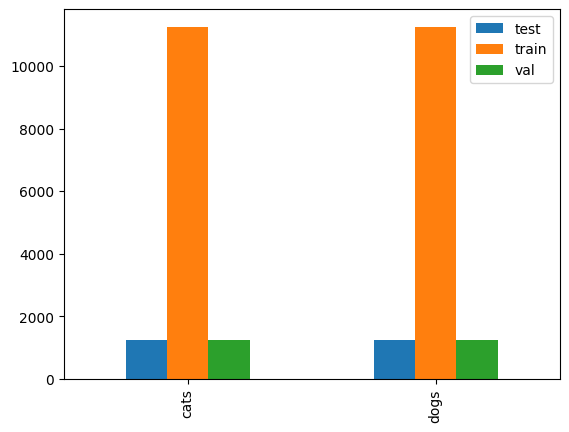

In [5]:
DATA_DIR = "./data/"
img_data = {}

for folder in os.listdir(DATA_DIR):
    subfolder_path = DATA_DIR + folder + '/'
    img_data[folder] = {}
    for subfolder in os.listdir(subfolder_path):
        img_data[folder][subfolder] = len(os.listdir(subfolder_path + subfolder))

df = pd.DataFrame.from_dict(img_data, orient='index')
df.T.plot(kind='bar')

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  #随机裁剪一个area然后再resize
        transforms.RandomHorizontalFlip(),  #随机水平翻转
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=16)
               for x in ['train', 'val', 'test']}
train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Label mapping
class_mapping = image_datasets['train'].class_to_idx

class_names = image_datasets['train'].classes
print(class_names)

['cats', 'dogs']


In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [9]:
# # 获取一批训练数据
# images, labels = next(iter(train_loader))

# # 批量制作网格
# out = torchvision.utils.make_grid(images)

# imshow(out, title=[class_names[x] for x in labels])

In [10]:
def validation(model, criterion, val_loader):
    val_loss = 0
    accuracy = 0

    for images, labels in iter(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images.to(device))
        val_loss += criterion(logits, labels).item()

        probabilities = torch.exp(logits)

        equality = labels.data == probabilities.max(dim=1)[1]
        accuracy += equality.type(torch.FloatTensor).mean()

    return val_loss, accuracy

In [11]:
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    plot_training = []
    plot_validation = []

    for e in range(epochs):
        model.train()
        training_loss = 0.0

        for images, labels in iter(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item() * images.size(0)
            # training_loss += loss.item()

        # Evaluate performance of each epoch
        model.eval()

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            val_loss, val_accuracy = validation(model, criterion, val_loader)
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())

        print(
            "Epoch: {}/{}.. ".format(e + 1, epochs),
            "Training Loss: {:.3f}.. ".format(training_loss),
            "Validation Loss: {:.3f}.. ".format(
                val_loss / len(val_loader)
            ),
            "Validation Accuracy: {:.3f}".format(val_accuracy / len(val_loader)),
        )

        plot_training.append(training_loss)
        plot_validation.append(val_loss / len(val_loader))
    
    plt.plot(range(len(plot_training)), plot_training, label='training')
    plt.plot(range(len(plot_validation)), plot_validation, label='validation')
    plt.legend()
    plt.show()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

In [29]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            _, preds = torch.max(logits, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(images.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
def save_checkpoint(model, class_mapping, timestamp, arch):
    """
    Save trained model weights.

    Input:
    arch(str): Model architecture
    """

    checkpoint = {
        "arch": arch,
        "class_to_idx": class_mapping,
        "model_state_dict": model.state_dict(),
    }

    torch.save(checkpoint, f"./checkpoint/{timestamp}_{arch}.pth")

In [22]:
def load_checkpoint(filepath, class_mapping):
    """
    Loads a checkpoint and rebuilds the model.

    Input:
    filepath(str): Relative path to model checkpoint
    """
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath)
        num_classes = len(class_mapping)

        if "resnet50" in checkpoint["arch"]:
            model = models.resnet50()
            num_ftrs = model.fc.in_features
            classifier = nn.Sequential(
                OrderedDict(
                    [
                        ("fc", nn.Linear(num_ftrs, num_classes)),
                        ("output", nn.LogSoftmax(dim=1)),
                    ]
                )
            )
            model.fc = classifier       
        else:
            return print("Architecture not recognized.")

        for param in model.parameters():
            param.requires_grad = False

        model.class_to_idx = checkpoint["class_to_idx"]        
        model.load_state_dict(checkpoint["model_state_dict"])

        return model
    
    else:
        print("No such checkpoint found.")

In [13]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False

In [14]:
print("Original final layer")
print(model.fc)

# Build custom classifier
num_classes = len(class_names)
print(num_classes)
num_ftrs = model.fc.in_features
classifier = nn.Sequential(
    OrderedDict(
        [
            ("fc", nn.Linear(num_ftrs, num_classes)),
            ("output", nn.LogSoftmax(dim=1)),
        ]
    )
)
model.fc = classifier

print("\nModified final layer")
print(model.fc)
model.fc.to(device)

Original final layer
Linear(in_features=2048, out_features=1000, bias=True)
2

Modified final layer
Sequential(
  (fc): Linear(in_features=2048, out_features=2, bias=True)
  (output): LogSoftmax(dim=1)
)


Sequential(
  (fc): Linear(in_features=2048, out_features=2, bias=True)
  (output): LogSoftmax(dim=1)
)

In [15]:
# Loss function and gradient descent
criterion = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.0001)  # 定义优化器

Epoch: 1/5..  Training Loss: 227.938..  Validation Loss: 0.033..  Validation Accuracy: 0.990
Epoch: 2/5..  Training Loss: 187.336..  Validation Loss: 0.028..  Validation Accuracy: 0.992
Epoch: 3/5..  Training Loss: 181.545..  Validation Loss: 0.029..  Validation Accuracy: 0.994
Epoch: 4/5..  Training Loss: 174.714..  Validation Loss: 0.027..  Validation Accuracy: 0.992
Epoch: 5/5..  Training Loss: 168.073..  Validation Loss: 0.024..  Validation Accuracy: 0.991


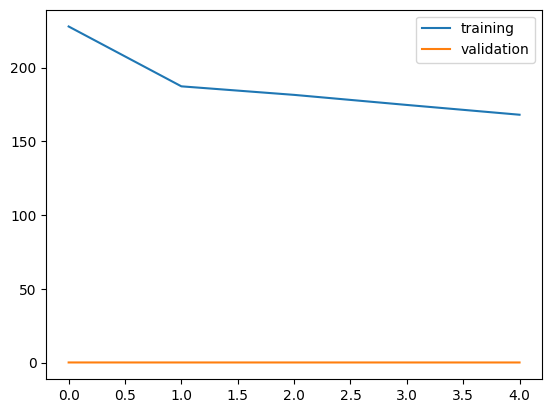

Training complete in 6m 43s


In [16]:
# Train model
resnet_model = train_model(model, optimizer, criterion, train_loader, val_loader)

In [17]:
timestamp = datetime.now().date().strftime("%Y%m%d")
arch = 'resnet50'

save_checkpoint(resnet_model, class_mapping, timestamp, arch)

In [23]:
model = load_checkpoint(f'./checkpoint/{timestamp}_{arch}.pth', class_mapping)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
visualize_model(resnet_model)

In [28]:
from sklearn.metrics import classification_report

with torch.no_grad():
    predictions = []
    true_labels = []

    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images.to(device))
        probabilities = torch.exp(logits)
        predictions += probabilities.max(dim=1)[1].tolist()
        true_labels += labels.tolist()

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1250
           1       0.99      0.98      0.98      1250

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500

